In [1]:
# cat&dog csv 파일을 이용한 분류
# kaggle에서 cat&dog 이미지를 가져와 jupyternotebook에서 이미지 처리를 해준 후 csv파일로 만듦
# 그 csv 파일을 가져와
# 전체 이미지 학습과 평가
# CNN으로 구현

In [2]:
# 필요한 module import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# Raw Data Loading

df = pd.read_csv('/content/drive/MyDrive/KOSA3/data/cat_dog/train.csv')
display(df.head(), df.shape) # (25000, 6401)

,label,0,1,2,3,4,5,6,7,8,...,6390,6391,6392,6393,6394,6395,6396,6397,6398,6399
0,0,41,9,12,16,29,28,20,33,29,...,74,57,43,47,9,36,8,2,3,3
1,1,15,19,20,19,13,16,25,17,11,...,91,84,91,90,88,82,90,89,97,91
2,1,82,88,93,96,98,101,101,100,102,...,28,31,36,36,36,36,37,36,35,35
3,0,103,103,101,99,101,99,98,98,98,...,176,174,173,172,172,172,172,170,170,169
4,0,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


(25000, 6401)

In [4]:
# label(target) data와 pixel data를 분리해봤다
# 데이터 확인하기 위해
label_data = df['label'].values # 1차원 ndarray
pixel_data = df.drop('label', axis=1, inplace=False).values # inplace=False로 잡아야 복사본이 나오지 않는다 # 2차원 ndarray

1


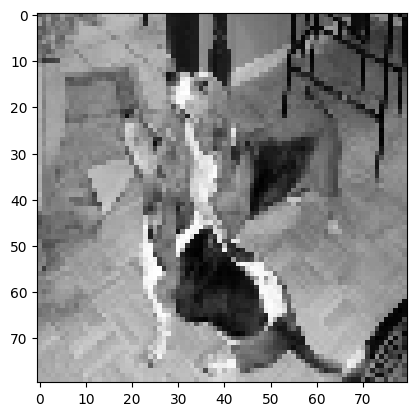

In [5]:
# 샘플 이미지 확인
plt.imshow(pixel_data[152].reshape(80,80), cmap='gray') # 원래 imshow는 3차원이 들어가야 하기 때문에 2차원으로 만들어주기 위해서 cmap='gray'를 넣어준다
print(label_data[152])
plt.show()

In [6]:
# 데이터 전처리
# 우리가 직접 프로그램을 짜서 pixel_data를 뽑은 것이기 때문에
# 결측치, 이상치 없다는 것을 안다
# 하지만, 다른 곳에서 가져온 것이라면 데이터 전처리 작업을 꼭 거쳐야 한다

# 1. 결측치 : 없음
# 2. 이상치 : 없음
# 3. 데이터 정규화 처리
scaler = MinMaxScaler()
scaler.fit(pixel_data)
x_data_norm = scaler.transform(pixel_data)

In [7]:
# 4. train, test 분리
x_data_train_norm, x_data_test_norm, t_data_train, t_data_test = \
train_test_split(x_data_norm,
                 label_data.reshape(-1,1),
                 test_size=0.3)

In [8]:
# 5. Model 구현
# 이 모든 것은 내 마음이지만, 기준은 있다
# 이미지 크기가 클 수록 Pooling을 많이 땡긴다


model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(3,3), # kernel_size는 일반적으로 3x3을 쓴다
                 strides=(1,1),
                 activation='relu',
                 padding='same',
                 input_shape=(80,80,1))) # 흑백이기 때문에

model.add(MaxPooling2D(pool_size=(2,2))) # 이미지 크기를 반으로 준다 -> 이미지의 크기가 주니까 필터의 수를 늘려주는게 좋다

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2))) # 한 번더 이미지 크기를 줄였기 때문에

model.add(Conv2D(filters=128,            # 여기서 필터의 개수를 늘려주었다
                 kernel_size=(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu'))

model.add(Conv2D(filters=256,
                 kernel_size=(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256,
                 kernel_size=(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 40, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 256)       2

In [9]:
# FC Layer(Classifier 분류기)
model.add(Flatten())

model.add(Dense(units=256,
                activation='relu'))

model.add(Dropout(rate=0.4))

# 이진 분류이기 때문에 units=1, activation은 sigmoid로 주기
model.add(Dense(units=1,
                activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 40, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 256)       2

In [10]:
# 학습 설정하고 학습 진행!
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 일반적으로 callback을 설정해요!
# 우리는 callback을 설정하지 않고 학습을 진행

history = model.fit(x_data_train_norm.reshape(-1,80,80,1),
                    t_data_train,
                    epochs=100,
                    verbose=1,
                    batch_size=100,
                    validation_split=0.3)

Epoch 1/100
123/123 [==============================] - 19s 50ms/step - loss: 0.6819 - accuracy: 0.5491 - val_loss: 0.6596 - val_accuracy: 0.6213
Epoch 2/100
123/123 [==============================] - 5s 38ms/step - loss: 0.6281 - accuracy: 0.6473 - val_loss: 0.6190 - val_accuracy: 0.6579
Epoch 3/100
123/123 [==============================] - 5s 39ms/step - loss: 0.5880 - accuracy: 0.6864 - val_loss: 0.6308 - val_accuracy: 0.6427
Epoch 4/100
123/123 [==============================] - 5s 40ms/step - loss: 0.5657 - accuracy: 0.7073 - val_loss: 0.5564 - val_accuracy: 0.7137
Epoch 5/100
123/123 [==============================] - 5s 38ms/step - loss: 0.5386 - accuracy: 0.7266 - val_loss: 0.5305 - val_accuracy: 0.7322
Epoch 6/100
123/123 [==============================] - 5s 40ms/step - loss: 0.5032 - accuracy: 0.7533 - val_loss: 0.5211 - val_accuracy: 0.7432
Epoch 7/100
123/123 [==============================] - 5s 39ms/step - loss: 0.4707 - accuracy: 0.7758 - val_loss: 0.4921 - val_accuracy

In [11]:
# 학습이 잘 되었다는 가정 하에 모델 평가 진행
# (수업시간에 돌리고 있는 와중에 평가 코드부터 입력)

print(model.evaluate(x_data_test_norm.reshape(-1, 80, 80, 1,),
                     t_data_test)) # [0.8430220484733582, 0.8325333595275879]

235/235 [==============================] - 2s 7ms/step - loss: 0.8430 - accuracy: 0.8325
[0.8430220484733582, 0.8325333595275879]


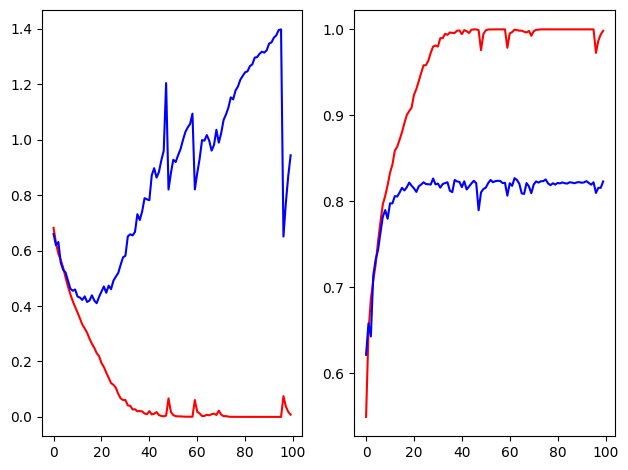

In [13]:
# 마지막으로 그래프 그리기
fig = plt.figure()


ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')

ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

plt.tight_layout()
plt.show()

In [ ]:
# ImageDataGenerator를 이용하기 위해서
# 우리가 가진 개와 고양이 데이터를 특정 폴더구조로 변경해 보아요!

import os, shutil

original_dataset_dir = './data/cat_dog/train'

base_dir = 'data/cat_dog_full'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir,'train').replace('\\','/')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir,'validation').replace('\\','/')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir,'test').replace('\\','/')
os.mkdir(test_dir)


train_cats_dir = os.path.join(train_dir,'cats').replace('\\','/')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir,'dogs').replace('\\','/')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir,'cats').replace('\\','/')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir,'dogs').replace('\\','/')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir,'cats').replace('\\','/')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir,'dogs').replace('\\','/')
os.mkdir(test_dogs_dir)

## file 복사 ##
## 고양이와 멍멍이가 각각 12,500개
## train : 7,000
## validation : 3,000
## test : 2,500

fnames = ['cat.{}.jpg'.format(i) for i in range(7000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname).replace('\\','/')
    dst = os.path.join(train_cats_dir, fname).replace('\\','/')
    shutil.copyfile(src,dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(7000,10000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname).replace('\\','/')
    dst = os.path.join(validation_cats_dir, fname).replace('\\','/')
    shutil.copyfile(src,dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(10000,12500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname).replace('\\','/')
    dst = os.path.join(test_cats_dir, fname).replace('\\','/')
    shutil.copyfile(src,dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(7000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname).replace('\\','/')
    dst = os.path.join(train_dogs_dir, fname).replace('\\','/')
    shutil.copyfile(src,dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(7000,10000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname).replace('\\','/')
    dst = os.path.join(validation_dogs_dir, fname).replace('\\','/')
    shutil.copyfile(src,dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(10000,12500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname).replace('\\','/')
    dst = os.path.join(test_dogs_dir, fname).replace('\\','/')
    shutil.copyfile(src,dst)